In [1]:
import os

import torch
from torch import nn

# import torchmetrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import librosa

import joblib

from typing import List

# Model

In [2]:
class MusicClassifier(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(
                in_features=input_features, out_features=256, dtype=torch.float32
            ),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=128, dtype=torch.float32),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(
                in_features=128, out_features=output_features, dtype=torch.float32
            ),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Functions

In [3]:
genre_mapping = {
    0: "Blues",
    1: "Classical",
    2: "Country",
    3: "Disco",
    4: "Hiphop",
    5: "Jazz",
    6: "Metal",
    7: "Pop",
    8: "Reggae",
    9: "Rock",
}

In [4]:
genre_mapping_inverse = {
    "Blues": 0,
    "Classical": 1,
    "Country": 2,
    "Disco": 3,
    "Hiphop": 4,
    "Jazz": 5,
    "Metal": 6,
    "Pop": 7,
    "Reggae": 8,
    "Rock": 9,
}

In [5]:
column_names = [
    "chroma_stft_mean",
    "chroma_stft_var",
    "rms_mean",
    "rms_var",
    "spectral_centroid_mean",
    "spectral_centroid_var",
    "spectral_bandwidth_mean",
    "spectral_bandwidth_var",
    "rolloff_mean",
    "rolloff_var",
    "zero_crossing_rate_mean",
    "zero_crossing_rate_var",
    "harmony_mean",
    "harmony_var",
    "tempo",
    "mfcc1_mean",
    "mfcc1_var",
    "mfcc2_mean",
    "mfcc2_var",
    "mfcc3_mean",
    "mfcc3_var",
    "mfcc4_mean",
    "mfcc4_var",
    "mfcc5_mean",
    "mfcc5_var",
    "mfcc6_mean",
    "mfcc6_var",
    "mfcc7_mean",
    "mfcc7_var",
    "mfcc8_mean",
    "mfcc8_var",
    "mfcc9_mean",
    "mfcc9_var",
    "mfcc10_mean",
    "mfcc10_var",
    "mfcc11_mean",
    "mfcc11_var",
    "mfcc12_mean",
    "mfcc12_var",
    "mfcc13_mean",
    "mfcc13_var",
    "mfcc14_mean",
    "mfcc14_var",
    "mfcc15_mean",
    "mfcc15_var",
    "mfcc16_mean",
    "mfcc16_var",
    "mfcc17_mean",
    "mfcc17_var",
    "mfcc18_mean",
    "mfcc18_var",
    "mfcc19_mean",
    "mfcc19_var",
    "mfcc20_mean",
    "mfcc20_var",
]

In [6]:
def get_3sec_sample(song_path) -> list:
    # TODO Vérif
    # TODO Rewrite
    audio, sample_rate = librosa.load(song_path, sr=None)

    segment_duration = 3  # Durée de chaque segment en secondes
    segment_length = int(sample_rate * segment_duration)
    segments = []

    # Effectuez la prédiction toutes les 3 secondes
    for i in range(0, len(audio), segment_length):
        segment = audio[i : i + segment_length]
        segments.append(segment)

    return segments

In [7]:
def audio_pipeline(audio):
    features = []

    # Chromagram
    chroma_stft = librosa.feature.chroma_stft(y=audio)
    features.append(np.mean(chroma_stft))
    features.append(np.var(chroma_stft))  # var => variance

    # RMS (Root Mean Square value for each frame)
    rms = librosa.feature.rms(y=audio)
    features.append(np.mean(rms))
    features.append(np.var(rms))

    # Calcul du Spectral centroid
    spectral_centroids = librosa.feature.spectral_centroid(y=audio)
    features.append(np.mean(spectral_centroids))
    features.append(np.var(spectral_centroids))

    # Spectral bandwith
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio)
    features.append(np.mean(spectral_bandwidth))
    features.append(np.var(spectral_bandwidth))

    # Calcul du spectral rolloff point
    rolloff = librosa.feature.spectral_rolloff(y=audio)
    features.append(np.mean(rolloff))
    features.append(np.var(rolloff))

    # Calcul du ZCR (Zero Crossing Rate)
    zcr = librosa.zero_crossings(audio)
    # features.append(np.sum(zcr))  # Custom
    features.append(np.mean(zcr))
    features.append(np.var(zcr))

    # Harmonic
    harmony = librosa.effects.harmonic(y=audio)
    features.append(np.mean(harmony))
    features.append(np.var(harmony))

    # Tempo
    tempo = librosa.feature.tempo(y=audio)
    features.append(tempo[0])

    # Calcul des moyennes des MFCC
    mfcc = librosa.feature.mfcc(y=audio)
    for x in mfcc:
        features.append(np.mean(x))
        features.append(np.var(x))

    return features

In [8]:
def preprocess_data(song_path):
    scaler = joblib.load("../resources/standard_scaler_pytorch_model_last.pkl")
    dfs = []
    segments = get_3sec_sample(song_path)

    for audio in segments:
        # Perform audio feature extraction
        features = audio_pipeline(audio)

        # Scale the features using the loaded scaler
        scaled_features = scaler.transform([features])

        # Create a DataFrame
        df = pd.DataFrame(scaled_features, columns=column_names)
        dfs.append(df)
    
    return dfs

    # print(len(dfs), " 3sec samples extracted and preprocessed")


In [9]:
def concat_dfs(dfs: List[pd.DataFrame], real_class):
    # Creating new df from processed input
    for i in range(len(dfs)):
        if i == 0:
            new_df = pd.DataFrame(dfs[i], columns=column_names)
        else:
            new_df = pd.concat([new_df, dfs[i]], axis=0)
    new_df["label"] = real_class

    # Créer dataset enrichie (csv)
    original_df = pd.read_csv(
        "./csv/actual_dataset.csv"
    )

    concatened_dataset = pd.concat([original_df, new_df], axis=0)

    concatened_dataset.to_csv("./csv/actual_dataset.csv", index=False)

In [10]:
def training_loop(MusicClassifier):
    # Init le model
    torch.manual_seed(42)
    model = MusicClassifier(input_features=55, output_features=10)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.011)

    def accuracy_fn(y_true, y_pred):
        correct = (
            torch.eq(input=y_true, other=y_pred).sum().item()
        )  # torch.eq() calculates where two tensors are equal
        acc = (correct / len(y_pred)) * 100  # Calcul simple de pourcentage
        return acc

    # Prepare data
    df = pd.read_csv("./csv/actual_dataset.csv")
    # df = pd.read_csv("/app/resources/original_dataset.csv")
    X = torch.from_numpy(df.drop(columns=["label"]).to_numpy()).type(torch.float32)
    y = torch.from_numpy(df["label"].to_numpy()).type(torch.long)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Training loop
    torch.manual_seed(42)
    epochs = 125
    for epoch in range(epochs + 1):
        """
        Train
        """
        model.train()

        # 1. Forward pass
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # 2. Metrics
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

        # 2.1 Save metrics
        # loss_history.append(loss.cpu().detach().numpy())
        # acc_history.append(acc)

        # 3. Zero Grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimmizer step
        optimizer.step()

        """
        Test
        """
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass
            y_test_logits = model(X_test)
            y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

            # 2. Metrics
            test_loss = loss_fn(y_test_logits, y_test)
            test_acc = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

            # 2.1 Save metrics
            # test_loss_history.append(test_loss.cpu().detach().numpy())
            # test_acc_history.append(test_acc)

        # Print out what's happening
        if epoch % 25 == 0:
                print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

    # if epoch == 125:
    cm = confusion_matrix(y_test, y_test_pred.numpy())
    ConfusionMatrixDisplay(cm).plot()
    # Save the model
    torch.save(obj=model.state_dict(), f="./actual_model_fast.pth")

# Main


1. ------------ Preprocessing ---------------

Song => Zach Bryan - Something In The Orange_lA8F9sIhGdg.mp3
Class => 2


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(



2. ----------- Predict --------------------

Classical 6
Disco 2
Pop 1
Rock 9
Jazz 6
Reggae 26
Hiphop 34
Blues 4
Results => Hiphop ( 4 )

3. ----------- Filter kept data --------------------

real_class 2

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28855, Acc: 13.12% | Test Loss: 1.87892, Test Acc: 37.05%
Epoch: 25 | Loss: 0.60456, Acc: 78.64% | Test Loss: 0.64657, Test Acc: 77.63%
Epoch: 50 | Loss: 0.30438, Acc: 89.26% | Test Loss: 0.45135, Test Acc: 85.27%
Epoch: 75 | Loss: 0.16542, Acc: 94.02% | Test Loss: 0.38262, Test Acc: 88.59%
Epoch: 100 | Loss: 0.10426, Acc: 96.69% | Test Loss: 0.38542, Test Acc: 89.78%
Epoch: 125 | Loss: 0.07353, Acc: 97.64% | Test Loss: 0.39617, Test Acc: 90.23%

1. ------------ Preprocessing ---------------

Song => country00001.mp3
Class => 2

2. ----------- Predict --------------------

Country 10
Results => Country ( 2 )

3. ----------- Filter kept data --------------------

real_cl

/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(



2. ----------- Predict --------------------

Rock 1
Jazz 2
Blues 2
Country 76
Results => Country ( 2 )

3. ----------- Filter kept data --------------------

real_class 2

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28943, Acc: 12.87% | Test Loss: 1.89127, Test Acc: 36.97%
Epoch: 25 | Loss: 0.61189, Acc: 78.52% | Test Loss: 0.64222, Test Acc: 77.04%
Epoch: 50 | Loss: 0.31755, Acc: 89.06% | Test Loss: 0.44275, Test Acc: 86.18%
Epoch: 75 | Loss: 0.16848, Acc: 93.93% | Test Loss: 0.37957, Test Acc: 88.84%
Epoch: 100 | Loss: 0.10627, Acc: 96.32% | Test Loss: 0.37033, Test Acc: 90.12%
Epoch: 125 | Loss: 0.07030, Acc: 97.78% | Test Loss: 0.36674, Test Acc: 91.05%

1. ------------ Preprocessing ---------------

Song => 0_Achy Breaky Heart.mp3
Class => 2


/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(



2. ----------- Predict --------------------

Jazz 1
Country 68
Results => Country ( 2 )

3. ----------- Filter kept data --------------------

real_class 2

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28785, Acc: 13.00% | Test Loss: 1.88852, Test Acc: 37.21%
Epoch: 25 | Loss: 0.59713, Acc: 79.00% | Test Loss: 0.64931, Test Acc: 78.12%
Epoch: 50 | Loss: 0.31084, Acc: 89.16% | Test Loss: 0.45320, Test Acc: 84.57%
Epoch: 75 | Loss: 0.17235, Acc: 94.00% | Test Loss: 0.37350, Test Acc: 88.43%
Epoch: 100 | Loss: 0.10332, Acc: 96.46% | Test Loss: 0.36463, Test Acc: 89.50%
Epoch: 125 | Loss: 0.07337, Acc: 97.58% | Test Loss: 0.35802, Test Acc: 90.62%

1. ------------ Preprocessing ---------------

Song => Willie Nelson - Live Forever.mp3
Class => 2


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(



2. ----------- Predict --------------------

Country 61
Results => Country ( 2 )

3. ----------- Filter kept data --------------------

real_class 2

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28650, Acc: 13.13% | Test Loss: 1.89050, Test Acc: 37.67%
Epoch: 25 | Loss: 0.59070, Acc: 79.43% | Test Loss: 0.64007, Test Acc: 78.20%
Epoch: 50 | Loss: 0.30141, Acc: 89.15% | Test Loss: 0.45868, Test Acc: 85.58%
Epoch: 75 | Loss: 0.17065, Acc: 94.15% | Test Loss: 0.40299, Test Acc: 88.20%
Epoch: 100 | Loss: 0.10590, Acc: 96.41% | Test Loss: 0.38705, Test Acc: 89.81%
Epoch: 125 | Loss: 0.07556, Acc: 97.50% | Test Loss: 0.39306, Test Acc: 90.78%

1. ------------ Preprocessing ---------------

Song => 0_Nocturne op.9 No.2.mp3
Class => 1

2. ----------- Predict --------------------

Classical 22
Jazz 57
Blues 5
Country 6
Results => Jazz ( 5 )

3. ----------- Filter kept data --------------------

real_class 1

4. ----------- C

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?



2. ----------- Predict --------------------

Classical 33
Rock 1
Jazz 10
Country 21
Reggae 4
Blues 6
Results => Classical ( 1 )

3. ----------- Filter kept data --------------------

real_class 1

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28536, Acc: 13.39% | Test Loss: 1.88227, Test Acc: 36.93%
Epoch: 25 | Loss: 0.59007, Acc: 79.12% | Test Loss: 0.64105, Test Acc: 77.83%
Epoch: 50 | Loss: 0.29022, Acc: 89.93% | Test Loss: 0.43829, Test Acc: 86.14%
Epoch: 75 | Loss: 0.15957, Acc: 94.62% | Test Loss: 0.37065, Test Acc: 89.01%
Epoch: 100 | Loss: 0.10121, Acc: 96.60% | Test Loss: 0.36140, Test Acc: 90.30%
Epoch: 125 | Loss: 0.06852, Acc: 97.78% | Test Loss: 0.35366, Test Acc: 91.45%

1. ------------ Preprocessing ---------------

Song => 1_Serenade.mp3
Class => 1


/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(



2. ----------- Predict --------------------

Classical 106
Jazz 13
Blues 4
Country 5
Results => Classical ( 1 )

3. ----------- Filter kept data --------------------

real_class 1

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28600, Acc: 13.02% | Test Loss: 1.85996, Test Acc: 37.09%
Epoch: 25 | Loss: 0.58278, Acc: 79.10% | Test Loss: 0.63863, Test Acc: 77.77%
Epoch: 50 | Loss: 0.30050, Acc: 89.60% | Test Loss: 0.43582, Test Acc: 85.37%
Epoch: 75 | Loss: 0.16127, Acc: 94.30% | Test Loss: 0.38458, Test Acc: 88.77%
Epoch: 100 | Loss: 0.10494, Acc: 96.41% | Test Loss: 0.38861, Test Acc: 89.48%
Epoch: 125 | Loss: 0.07059, Acc: 97.69% | Test Loss: 0.38156, Test Acc: 90.28%

1. ------------ Preprocessing ---------------

Song => Concerto Grosso for Strings _Palladio__ I. Allegretto_xUi0mM6-PJ0.mp3
Class => 1


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?



2. ----------- Predict --------------------

Classical 41
Country 11
Results => Classical ( 1 )

3. ----------- Filter kept data --------------------

real_class 1

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28494, Acc: 13.62% | Test Loss: 1.84136, Test Acc: 37.95%
Epoch: 25 | Loss: 0.60043, Acc: 78.85% | Test Loss: 0.59860, Test Acc: 78.06%
Epoch: 50 | Loss: 0.31309, Acc: 89.11% | Test Loss: 0.40613, Test Acc: 86.14%
Epoch: 75 | Loss: 0.18162, Acc: 93.55% | Test Loss: 0.34474, Test Acc: 89.53%
Epoch: 100 | Loss: 0.10698, Acc: 96.35% | Test Loss: 0.32738, Test Acc: 90.65%
Epoch: 125 | Loss: 0.07490, Acc: 97.77% | Test Loss: 0.34878, Test Acc: 90.93%

1. ------------ Preprocessing ---------------

Song => Ben Harper - Need To Know Basis_UXv53Nq8g_E.mp3
Class => 0


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(



2. ----------- Predict --------------------

Hiphop 8
Country 33
Results => Country ( 2 )

3. ----------- Filter kept data --------------------

real_class 0

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28419, Acc: 13.76% | Test Loss: 1.86021, Test Acc: 36.59%
Epoch: 25 | Loss: 0.59941, Acc: 78.98% | Test Loss: 0.62086, Test Acc: 78.90%
Epoch: 50 | Loss: 0.30097, Acc: 89.64% | Test Loss: 0.44014, Test Acc: 85.87%
Epoch: 75 | Loss: 0.16714, Acc: 94.30% | Test Loss: 0.38534, Test Acc: 89.42%
Epoch: 100 | Loss: 0.10233, Acc: 96.57% | Test Loss: 0.37516, Test Acc: 90.50%
Epoch: 125 | Loss: 0.07865, Acc: 97.38% | Test Loss: 0.39475, Test Acc: 90.13%

1. ------------ Preprocessing ---------------

Song => 0_Soul Blues Electric Guitar Instrumental.mp3
Class => 0


/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(



2. ----------- Predict --------------------

Classical 18
Blues 29
Country 12
Results => Blues ( 0 )

3. ----------- Filter kept data --------------------

real_class 0

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28487, Acc: 13.29% | Test Loss: 1.85750, Test Acc: 38.34%
Epoch: 25 | Loss: 0.59297, Acc: 79.14% | Test Loss: 0.62810, Test Acc: 78.13%
Epoch: 50 | Loss: 0.31618, Acc: 88.98% | Test Loss: 0.40871, Test Acc: 85.39%
Epoch: 75 | Loss: 0.17283, Acc: 94.10% | Test Loss: 0.34529, Test Acc: 88.79%
Epoch: 100 | Loss: 0.10282, Acc: 96.40% | Test Loss: 0.32537, Test Acc: 90.13%
Epoch: 125 | Loss: 0.07649, Acc: 97.44% | Test Loss: 0.33851, Test Acc: 90.97%

1. ------------ Preprocessing ---------------

Song => Wait Til I Get Over_0xhaweCEEzE.mp3
Class => 0


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?



2. ----------- Predict --------------------

Classical 39
Blues 2
Country 20
Results => Classical ( 1 )

3. ----------- Filter kept data --------------------

real_class 0

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28516, Acc: 12.82% | Test Loss: 1.86899, Test Acc: 37.11%
Epoch: 25 | Loss: 0.59627, Acc: 79.26% | Test Loss: 0.63945, Test Acc: 79.36%
Epoch: 50 | Loss: 0.30379, Acc: 89.59% | Test Loss: 0.43575, Test Acc: 85.75%
Epoch: 75 | Loss: 0.17232, Acc: 94.15% | Test Loss: 0.36197, Test Acc: 89.31%
Epoch: 100 | Loss: 0.10174, Acc: 96.70% | Test Loss: 0.36088, Test Acc: 90.33%
Epoch: 125 | Loss: 0.07205, Acc: 97.55% | Test Loss: 0.35829, Test Acc: 91.02%

1. ------------ Preprocessing ---------------

Song => 1_Blues.mp3
Class => 0

2. ----------- Predict --------------------

Classical 8
Jazz 3
Country 25
Reggae 4
Hiphop 13
Blues 6
Results => Country ( 2 )

3. ----------- Filter kept data --------------------


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(



2. ----------- Predict --------------------

Classical 2
Jazz 1
Blues 9
Country 47
Results => Country ( 2 )

3. ----------- Filter kept data --------------------

real_class 5

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28507, Acc: 12.92% | Test Loss: 1.89306, Test Acc: 35.33%
Epoch: 25 | Loss: 0.60118, Acc: 79.53% | Test Loss: 0.66978, Test Acc: 76.11%
Epoch: 50 | Loss: 0.30500, Acc: 89.56% | Test Loss: 0.45872, Test Acc: 84.81%
Epoch: 75 | Loss: 0.17177, Acc: 94.21% | Test Loss: 0.38147, Test Acc: 88.47%
Epoch: 100 | Loss: 0.10887, Acc: 96.44% | Test Loss: 0.36540, Test Acc: 90.11%
Epoch: 125 | Loss: 0.07688, Acc: 97.28% | Test Loss: 0.35864, Test Acc: 90.76%

1. ------------ Preprocessing ---------------

Song => La vie en rose - Louis Armstrong_8IJzYAda1wA.mp3
Class => 5


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?



2. ----------- Predict --------------------

Classical 18
Pop 23
Jazz 1
Country 17
Blues 10
Results => Pop ( 7 )

3. ----------- Filter kept data --------------------

real_class 5

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28732, Acc: 12.83% | Test Loss: 1.88355, Test Acc: 35.65%
Epoch: 25 | Loss: 0.60251, Acc: 79.06% | Test Loss: 0.64103, Test Acc: 78.49%
Epoch: 50 | Loss: 0.30996, Acc: 89.36% | Test Loss: 0.44030, Test Acc: 85.54%
Epoch: 75 | Loss: 0.17064, Acc: 94.12% | Test Loss: 0.38003, Test Acc: 88.72%
Epoch: 100 | Loss: 0.11315, Acc: 96.20% | Test Loss: 0.37085, Test Acc: 90.18%
Epoch: 125 | Loss: 0.08518, Acc: 97.18% | Test Loss: 0.37819, Test Acc: 90.59%

1. ------------ Preprocessing ---------------

Song => Numb (Official Music Video) [4K UPGRADE] – Linkin Park_kXYiU_JCYtU.mp3
Class => 9


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?



2. ----------- Predict --------------------

Classical 2
Jazz 7
Blues 1
Country 53
Results => Country ( 2 )

3. ----------- Filter kept data --------------------

real_class 9

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28724, Acc: 13.03% | Test Loss: 1.88557, Test Acc: 36.09%
Epoch: 25 | Loss: 0.61516, Acc: 78.35% | Test Loss: 0.68738, Test Acc: 77.34%
Epoch: 50 | Loss: 0.31646, Acc: 89.30% | Test Loss: 0.47427, Test Acc: 85.21%
Epoch: 75 | Loss: 0.17763, Acc: 93.89% | Test Loss: 0.41979, Test Acc: 88.15%
Epoch: 100 | Loss: 0.11211, Acc: 96.36% | Test Loss: 0.39833, Test Acc: 89.69%
Epoch: 125 | Loss: 0.07868, Acc: 97.52% | Test Loss: 0.41147, Test Acc: 89.78%

1. ------------ Preprocessing ---------------

Song => AC_DC Back in Black.mp3
Class => 9

2. ----------- Predict --------------------

Classical 2
Disco 5
Metal 2
Hiphop 1
Results => Disco ( 3 )

3. ----------- Filter kept data --------------------

real_

/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(



2. ----------- Predict --------------------

Classical 24
Disco 1
Rock 62
Jazz 1
Country 16
Blues 2
Results => Rock ( 9 )

3. ----------- Filter kept data --------------------

real_class 9

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28616, Acc: 13.01% | Test Loss: 1.88272, Test Acc: 36.38%
Epoch: 25 | Loss: 0.61454, Acc: 78.73% | Test Loss: 0.67222, Test Acc: 77.36%
Epoch: 50 | Loss: 0.31704, Acc: 89.02% | Test Loss: 0.47134, Test Acc: 85.28%
Epoch: 75 | Loss: 0.17894, Acc: 94.01% | Test Loss: 0.41851, Test Acc: 88.19%
Epoch: 100 | Loss: 0.10763, Acc: 96.58% | Test Loss: 0.39852, Test Acc: 89.84%
Epoch: 125 | Loss: 0.07871, Acc: 97.55% | Test Loss: 0.40797, Test Acc: 89.89%

1. ------------ Preprocessing ---------------

Song => 1_Roxanne.mp3
Class => 9

2. ----------- Predict --------------------

Classical 2
Rock 40
Country 15
Reggae 2
Hiphop 1
Blues 4
Results => Rock ( 9 )

3. ----------- Filter kept data ----

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?



2. ----------- Predict --------------------

Classical 3
Rock 67
Metal 3
Jazz 6
Country 16
Blues 7
Results => Rock ( 9 )

3. ----------- Filter kept data --------------------

real_class 9

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28536, Acc: 13.00% | Test Loss: 1.86762, Test Acc: 38.11%
Epoch: 25 | Loss: 0.62494, Acc: 78.23% | Test Loss: 0.63484, Test Acc: 78.37%
Epoch: 50 | Loss: 0.32217, Acc: 88.81% | Test Loss: 0.44307, Test Acc: 85.37%
Epoch: 75 | Loss: 0.18502, Acc: 93.76% | Test Loss: 0.39182, Test Acc: 88.46%
Epoch: 100 | Loss: 0.11646, Acc: 96.11% | Test Loss: 0.37828, Test Acc: 89.52%
Epoch: 125 | Loss: 0.08769, Acc: 97.22% | Test Loss: 0.39262, Test Acc: 90.44%

1. ------------ Preprocessing ---------------

Song => 1_Johnny Hallyday - Générique Pokémon.mp3
Class => 9


/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()



2. ----------- Predict --------------------

Rock 6
Reggae 2
Country 13
Results => Country ( 2 )

3. ----------- Filter kept data --------------------

real_class 9

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28491, Acc: 12.72% | Test Loss: 1.87303, Test Acc: 37.55%
Epoch: 25 | Loss: 0.62838, Acc: 78.39% | Test Loss: 0.63632, Test Acc: 77.57%
Epoch: 50 | Loss: 0.32208, Acc: 88.67% | Test Loss: 0.43908, Test Acc: 85.36%
Epoch: 75 | Loss: 0.18706, Acc: 93.72% | Test Loss: 0.37235, Test Acc: 88.79%
Epoch: 100 | Loss: 0.11762, Acc: 96.02% | Test Loss: 0.35666, Test Acc: 89.89%
Epoch: 125 | Loss: 0.08256, Acc: 97.12% | Test Loss: 0.36446, Test Acc: 90.24%

1. ------------ Preprocessing ---------------

Song => 0_Lets Groove.mp3
Class => 3

2. ----------- Predict --------------------

Rock 66
Jazz 1
Country 12
Results => Rock ( 9 )

3. ----------- Filter kept data --------------------

real_class 3

4. ----------- Conca

/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=119
  warnings.warn(



2. ----------- Predict --------------------

Disco 9
Country 1
Pop 1
Results => Disco ( 3 )

3. ----------- Filter kept data --------------------

real_class 3

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28530, Acc: 12.56% | Test Loss: 1.87857, Test Acc: 35.38%
Epoch: 25 | Loss: 0.61374, Acc: 78.49% | Test Loss: 0.64495, Test Acc: 78.40%
Epoch: 50 | Loss: 0.32656, Acc: 88.66% | Test Loss: 0.44798, Test Acc: 85.12%
Epoch: 75 | Loss: 0.18823, Acc: 93.53% | Test Loss: 0.36948, Test Acc: 88.53%
Epoch: 100 | Loss: 0.11863, Acc: 96.21% | Test Loss: 0.36853, Test Acc: 89.14%
Epoch: 125 | Loss: 0.08599, Acc: 96.97% | Test Loss: 0.36411, Test Acc: 89.92%

1. ------------ Preprocessing ---------------

Song => Daft Punk - Get Lucky (Official Audio) ft. Pharrell Williams, Nile Rodgers_5NV6Rdv1a3I.mp3
Class => 3


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?



2. ----------- Predict --------------------

Rock 52
Disco 1
Blues 9
Country 21
Results => Rock ( 9 )

3. ----------- Filter kept data --------------------

real_class 3

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28642, Acc: 12.45% | Test Loss: 1.87417, Test Acc: 36.86%
Epoch: 25 | Loss: 0.62030, Acc: 78.52% | Test Loss: 0.64596, Test Acc: 78.09%
Epoch: 50 | Loss: 0.33703, Acc: 88.57% | Test Loss: 0.44170, Test Acc: 85.40%
Epoch: 75 | Loss: 0.19662, Acc: 92.92% | Test Loss: 0.36483, Test Acc: 88.78%
Epoch: 100 | Loss: 0.11435, Acc: 96.35% | Test Loss: 0.34780, Test Acc: 89.69%
Epoch: 125 | Loss: 0.08710, Acc: 96.96% | Test Loss: 0.36575, Test Acc: 90.34%

1. ------------ Preprocessing ---------------

Song => 1_Don’t Stop Til You Get Enough.mp3
Class => 3

2. ----------- Predict --------------------

Rock 11
Disco 73
Classical 1
Results => Disco ( 3 )

3. ----------- Filter kept data --------------------

real_cl

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(



2. ----------- Predict --------------------

Classical 1
Disco 9
Rock 29
Country 50
Reggae 3
Blues 1
Results => Country ( 2 )

3. ----------- Filter kept data --------------------

real_class 3

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28643, Acc: 12.26% | Test Loss: 1.88535, Test Acc: 36.43%
Epoch: 25 | Loss: 0.61190, Acc: 78.90% | Test Loss: 0.65538, Test Acc: 78.11%
Epoch: 50 | Loss: 0.31458, Acc: 89.06% | Test Loss: 0.47077, Test Acc: 85.45%
Epoch: 75 | Loss: 0.18607, Acc: 93.60% | Test Loss: 0.41926, Test Acc: 88.52%
Epoch: 100 | Loss: 0.11619, Acc: 96.03% | Test Loss: 0.40343, Test Acc: 89.51%
Epoch: 125 | Loss: 0.08385, Acc: 97.11% | Test Loss: 0.39675, Test Acc: 90.44%

1. ------------ Preprocessing ---------------

Song => Lutan Fyah - Rasta Reggae Music (Official Music Video)_be67OhUSULg.mp3
Class => 8


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?



2. ----------- Predict --------------------

Classical 2
Disco 2
Rock 1
Country 77
Blues 3
Results => Country ( 2 )

3. ----------- Filter kept data --------------------

real_class 8

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28551, Acc: 12.60% | Test Loss: 1.88868, Test Acc: 35.71%
Epoch: 25 | Loss: 0.61291, Acc: 78.94% | Test Loss: 0.64158, Test Acc: 79.03%
Epoch: 50 | Loss: 0.32193, Acc: 88.79% | Test Loss: 0.44145, Test Acc: 85.85%
Epoch: 75 | Loss: 0.18430, Acc: 93.61% | Test Loss: 0.36035, Test Acc: 88.95%
Epoch: 100 | Loss: 0.11575, Acc: 96.05% | Test Loss: 0.35579, Test Acc: 90.26%
Epoch: 125 | Loss: 0.08350, Acc: 97.12% | Test Loss: 0.35637, Test Acc: 90.55%

1. ------------ Preprocessing ---------------

Song => onlymp3.to - Kabaka Pyramid The Kalling ft. Stephen Marley Protoje Jesse Royal Official Music Video -nf0itXfkHHo-192k-1693975416.mp3
Class => 8

2. ----------- Predict --------------------

Dis

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(



2. ----------- Predict --------------------

Classical 2
Disco 20
Rock 18
Jazz 1
Country 8
Reggae 1
Blues 38
Results => Blues ( 0 )

3. ----------- Filter kept data --------------------

real_class 7

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28579, Acc: 12.50% | Test Loss: 1.90518, Test Acc: 35.69%
Epoch: 25 | Loss: 0.61805, Acc: 78.68% | Test Loss: 0.63990, Test Acc: 78.48%
Epoch: 50 | Loss: 0.32424, Acc: 88.93% | Test Loss: 0.44648, Test Acc: 84.96%
Epoch: 75 | Loss: 0.18908, Acc: 93.44% | Test Loss: 0.39134, Test Acc: 88.42%
Epoch: 100 | Loss: 0.11392, Acc: 96.31% | Test Loss: 0.36421, Test Acc: 89.55%
Epoch: 125 | Loss: 0.09108, Acc: 97.07% | Test Loss: 0.37053, Test Acc: 90.22%

1. ------------ Preprocessing ---------------

Song => 1_Inspecteur Gadget.mp3
Class => 7

2. ----------- Predict --------------------

Classical 1
Disco 11
Pop 10
Rock 29
Jazz 1
Reggae 1
Results => Rock ( 9 )

3. ----------- Filter

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?



2. ----------- Predict --------------------

Classical 1
Disco 3
Rock 12
Country 35
Reggae 9
Hiphop 1
Blues 9
Results => Country ( 2 )

3. ----------- Filter kept data --------------------

real_class 7

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28252, Acc: 13.47% | Test Loss: 1.90694, Test Acc: 34.32%
Epoch: 25 | Loss: 0.62174, Acc: 78.37% | Test Loss: 0.68105, Test Acc: 78.18%
Epoch: 50 | Loss: 0.33733, Acc: 88.46% | Test Loss: 0.46880, Test Acc: 85.78%
Epoch: 75 | Loss: 0.18696, Acc: 93.72% | Test Loss: 0.42469, Test Acc: 88.16%
Epoch: 100 | Loss: 0.12403, Acc: 95.62% | Test Loss: 0.40401, Test Acc: 89.56%
Epoch: 125 | Loss: 0.09193, Acc: 96.92% | Test Loss: 0.39765, Test Acc: 89.97%

1. ------------ Preprocessing ---------------

Song => 1_Never Forget You.mp3
Class => 7

2. ----------- Predict --------------------

Classical 1
Disco 4
Pop 21
Rock 28
Jazz 1
Country 1
Reggae 15
Blues 1
Results => Rock ( 9 )

3

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(



2. ----------- Predict --------------------

Classical 1
Disco 3
Pop 49
Rock 4
Country 21
Blues 16
Results => Pop ( 7 )

3. ----------- Filter kept data --------------------

real_class 6

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28161, Acc: 13.41% | Test Loss: 1.89240, Test Acc: 34.96%
Epoch: 25 | Loss: 0.63241, Acc: 78.28% | Test Loss: 0.65195, Test Acc: 78.18%
Epoch: 50 | Loss: 0.32451, Acc: 88.87% | Test Loss: 0.42917, Test Acc: 86.66%
Epoch: 75 | Loss: 0.19064, Acc: 93.43% | Test Loss: 0.37653, Test Acc: 89.25%
Epoch: 100 | Loss: 0.12560, Acc: 95.71% | Test Loss: 0.36713, Test Acc: 90.43%
Epoch: 125 | Loss: 0.09775, Acc: 96.79% | Test Loss: 0.36806, Test Acc: 90.51%

1. ------------ Preprocessing ---------------

Song => Slipknot - The Devil In I [OFFICIAL VIDEO]_XEEasR7hVhA.mp3
Class => 6


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/l


2. ----------- Predict --------------------

Classical 18
Pop 1
Metal 77
Rock 17
Jazz 2
Country 3
Blues 1
Results => Metal ( 6 )

3. ----------- Filter kept data --------------------

real_class 6

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28174, Acc: 13.05% | Test Loss: 1.90531, Test Acc: 33.94%
Epoch: 25 | Loss: 0.62280, Acc: 78.58% | Test Loss: 0.68503, Test Acc: 77.51%
Epoch: 50 | Loss: 0.31763, Acc: 89.08% | Test Loss: 0.46880, Test Acc: 85.30%
Epoch: 75 | Loss: 0.18809, Acc: 93.55% | Test Loss: 0.40833, Test Acc: 88.11%
Epoch: 100 | Loss: 0.12046, Acc: 95.74% | Test Loss: 0.40348, Test Acc: 89.60%
Epoch: 125 | Loss: 0.09331, Acc: 96.83% | Test Loss: 0.40812, Test Acc: 90.28%

1. ------------ Preprocessing ---------------

Song => Cypecore The alliance.mp3
Class => 6

2. ----------- Predict --------------------

Rock 3
Disco 1
Metal 6
Results => Metal ( 6 )

3. ----------- Filter kept data ------------------

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?



2. ----------- Predict --------------------

Classical 3
Disco 4
Pop 62
Rock 1
Jazz 1
Country 7
Reggae 34
Hiphop 4
Blues 14
Results => Pop ( 7 )

3. ----------- Filter kept data --------------------

real_class 4

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28410, Acc: 13.23% | Test Loss: 1.91079, Test Acc: 32.65%
Epoch: 25 | Loss: 0.64486, Acc: 78.12% | Test Loss: 0.67231, Test Acc: 77.63%
Epoch: 50 | Loss: 0.32461, Acc: 88.49% | Test Loss: 0.44353, Test Acc: 85.61%
Epoch: 75 | Loss: 0.19286, Acc: 93.43% | Test Loss: 0.38317, Test Acc: 88.21%
Epoch: 100 | Loss: 0.13095, Acc: 95.58% | Test Loss: 0.36106, Test Acc: 89.92%
Epoch: 125 | Loss: 0.09549, Acc: 96.72% | Test Loss: 0.35779, Test Acc: 90.35%

1. ------------ Preprocessing ---------------

Song => Freeze Corleone 667 - Freeze Raël.mp3
Class => 4


/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/payetquentin/Documents/workspace/briefs/S9_music/Music/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate t


2. ----------- Predict --------------------

Classical 14
Pop 22
Rock 10
Metal 1
Jazz 4
Country 6
Reggae 8
Hiphop 26
Blues 14
Results => Hiphop ( 4 )

3. ----------- Filter kept data --------------------

real_class 4

4. ----------- Concat --------------------


5. ----------- Training loop --------------------

Epoch: 0 | Loss: 2.28588, Acc: 12.70% | Test Loss: 1.90708, Test Acc: 32.81%
Epoch: 25 | Loss: 0.64582, Acc: 77.86% | Test Loss: 0.66569, Test Acc: 78.23%
Epoch: 50 | Loss: 0.33971, Acc: 88.09% | Test Loss: 0.44905, Test Acc: 85.42%
Epoch: 75 | Loss: 0.19458, Acc: 93.29% | Test Loss: 0.41129, Test Acc: 88.62%
Epoch: 100 | Loss: 0.12737, Acc: 95.65% | Test Loss: 0.41393, Test Acc: 89.23%
Epoch: 125 | Loss: 0.09446, Acc: 96.73% | Test Loss: 0.41033, Test Acc: 90.12%

1. ------------ Preprocessing ---------------

Song => 0_Deep Cover.mp3
Class => 4

2. ----------- Predict --------------------

Classical 2
Disco 2
Pop 4
Metal 19
Jazz 56
Country 2
Blues 1
Results => Jazz ( 5 )

3

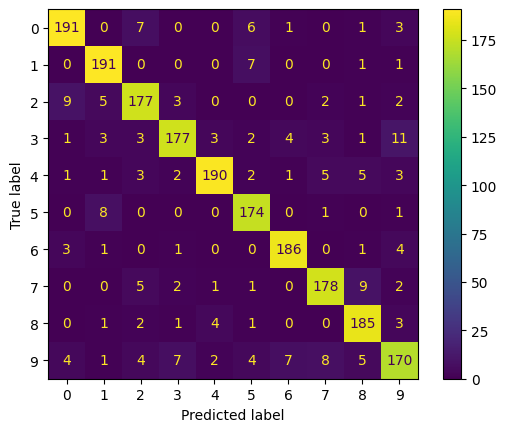

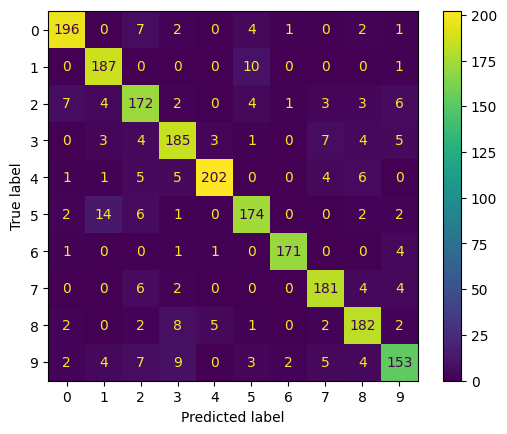

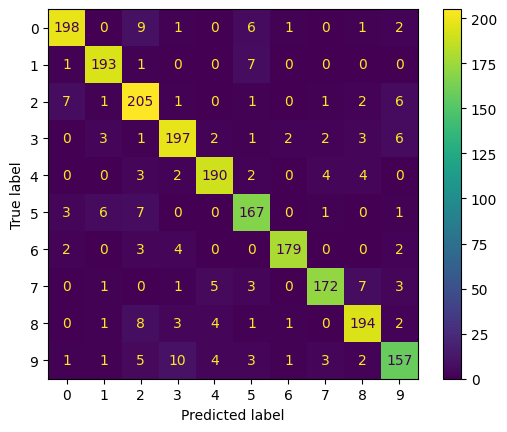

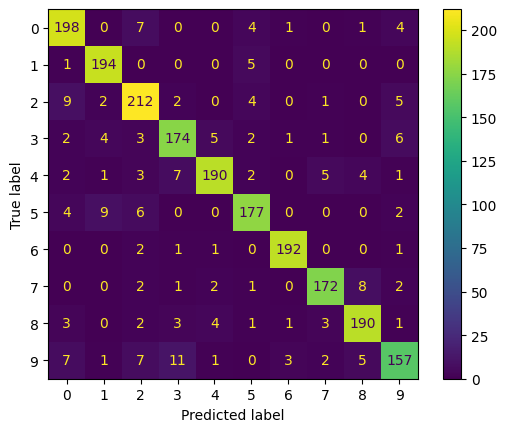

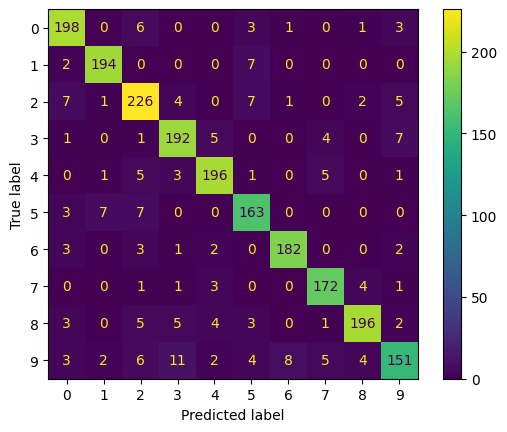

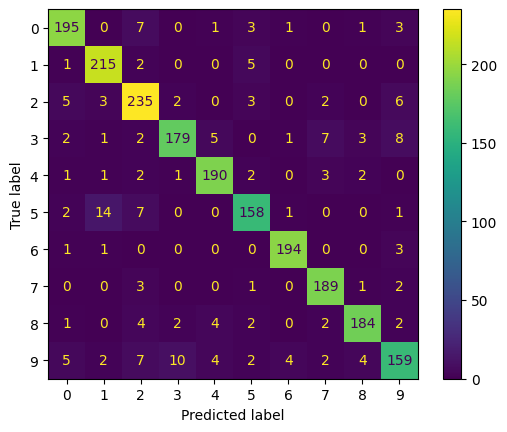

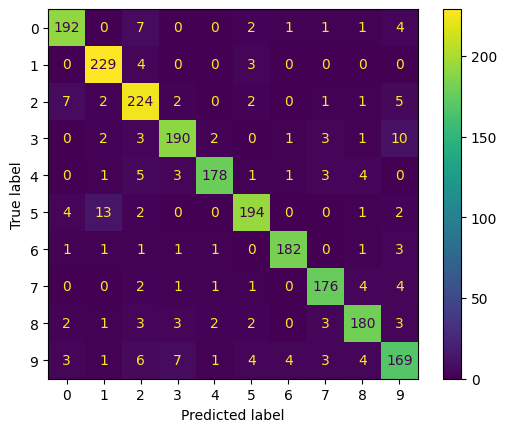

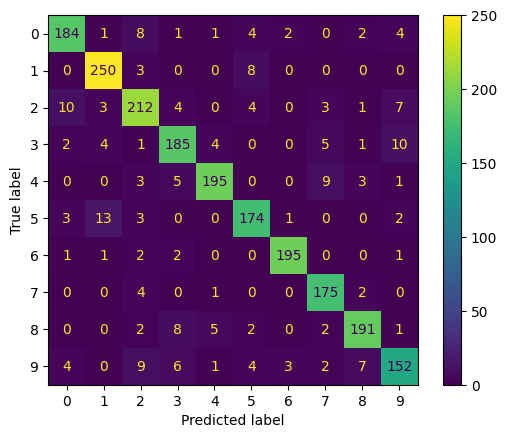

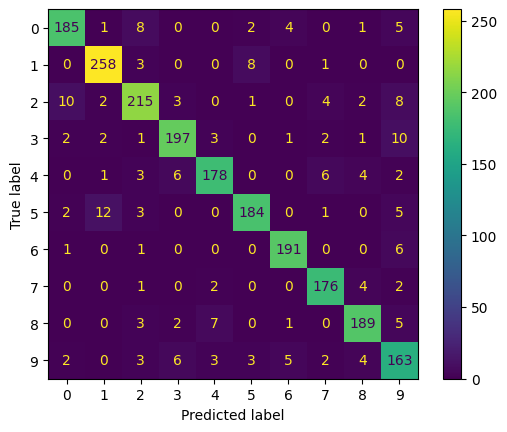

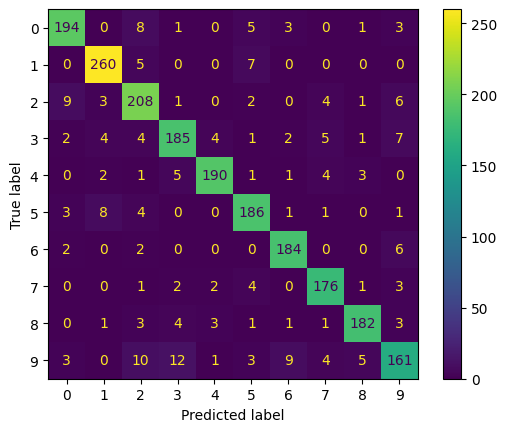

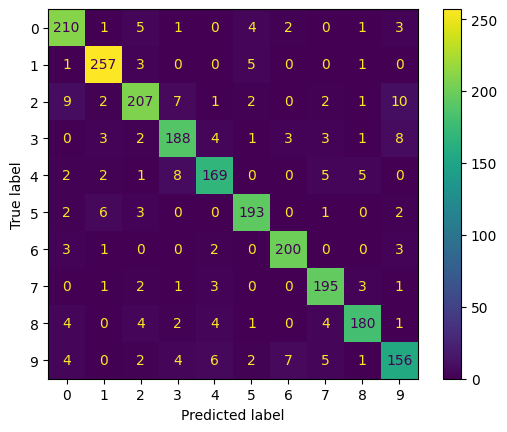

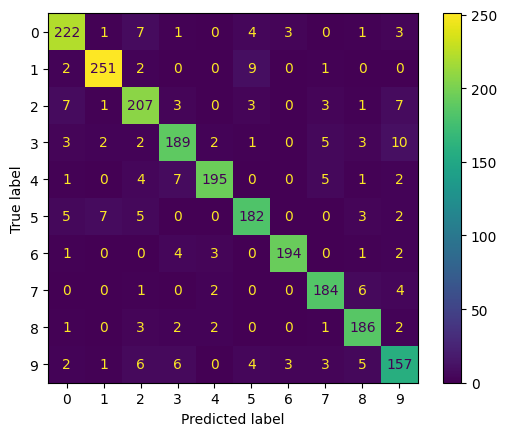

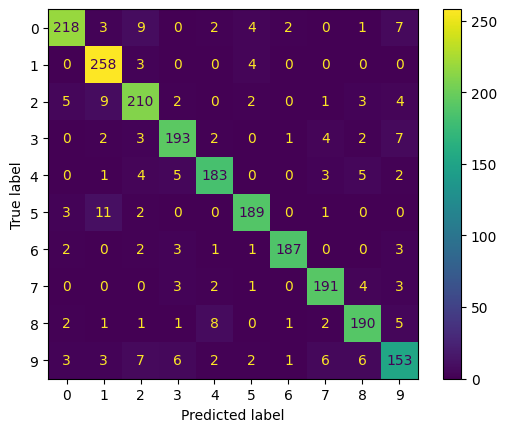

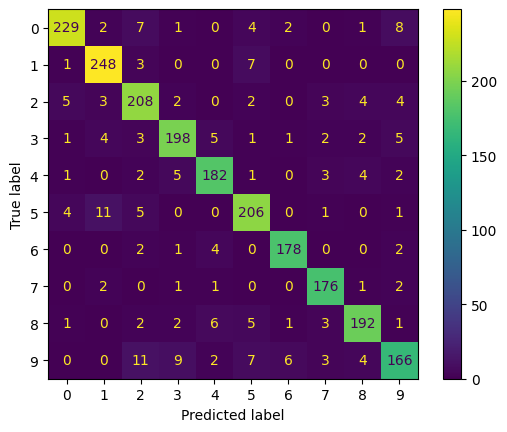

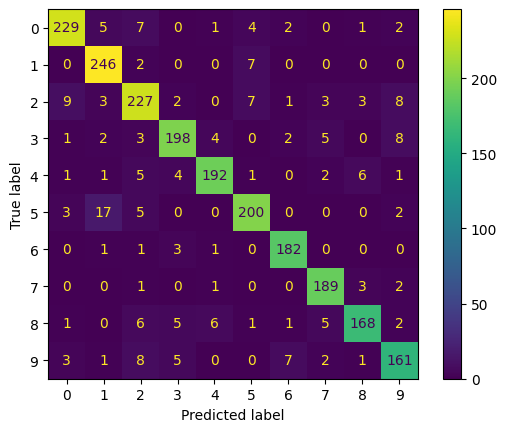

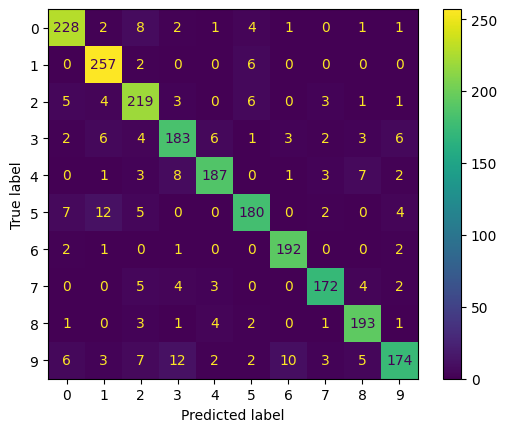

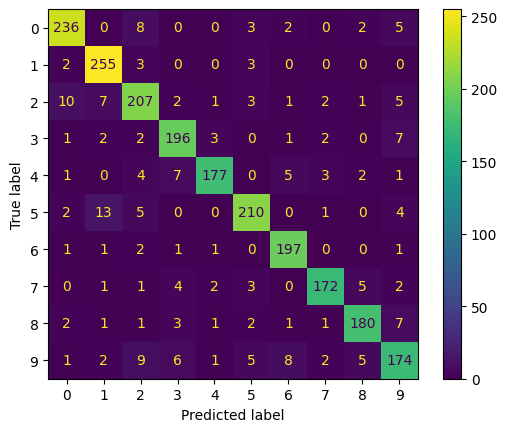

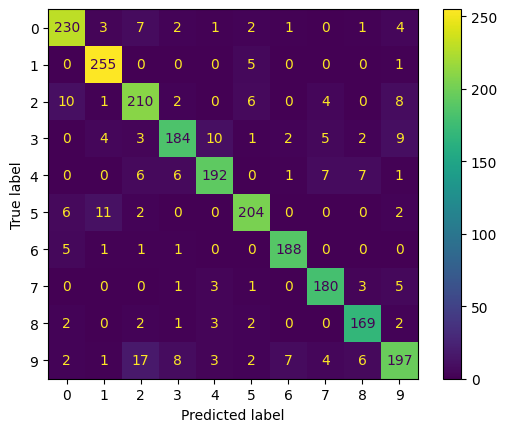

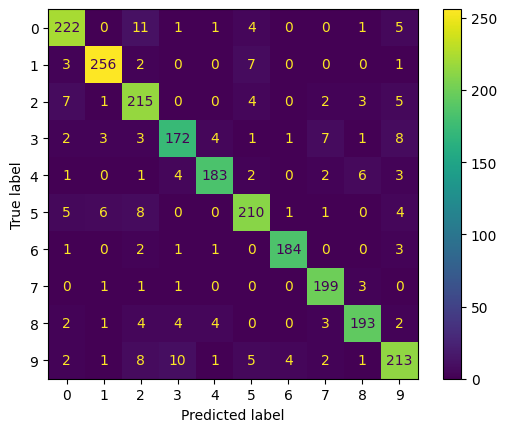

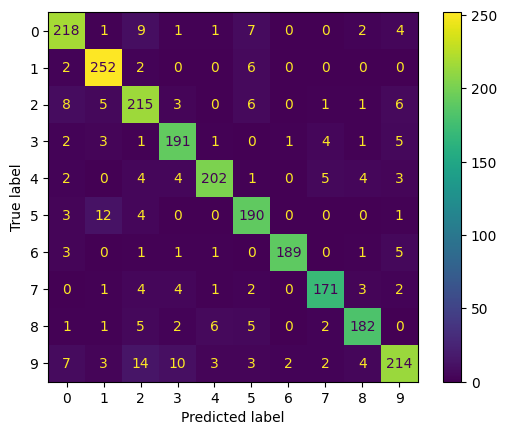

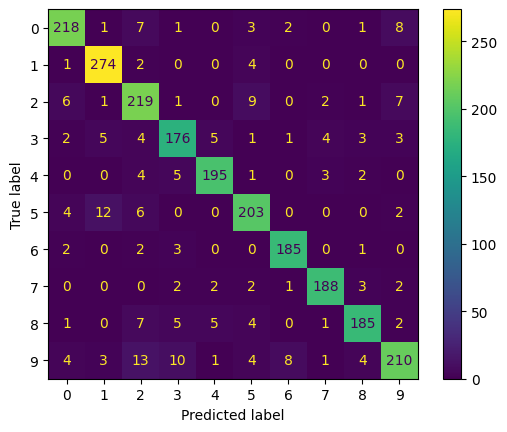

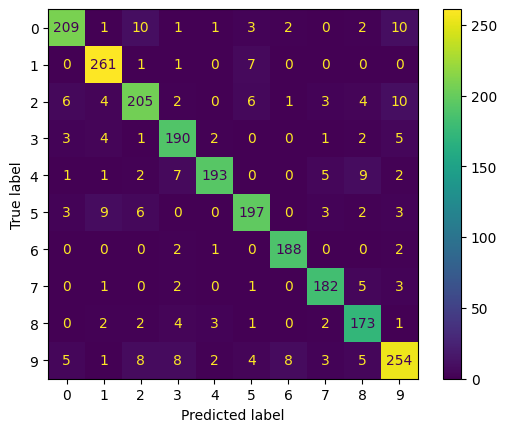

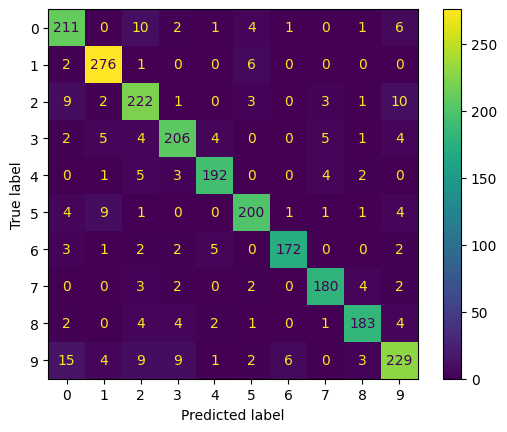

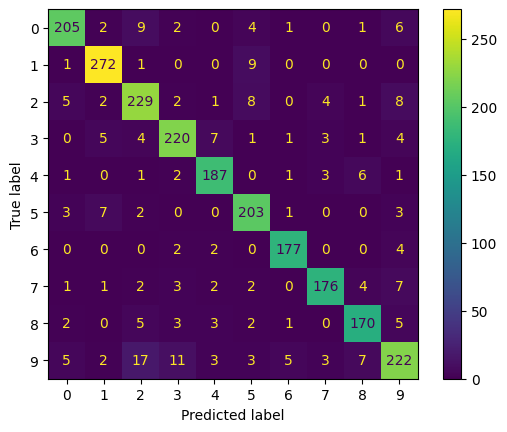

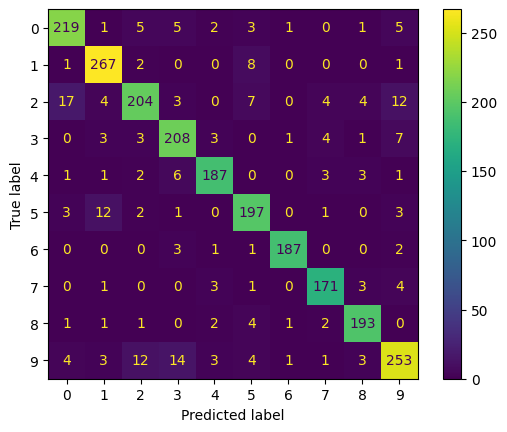

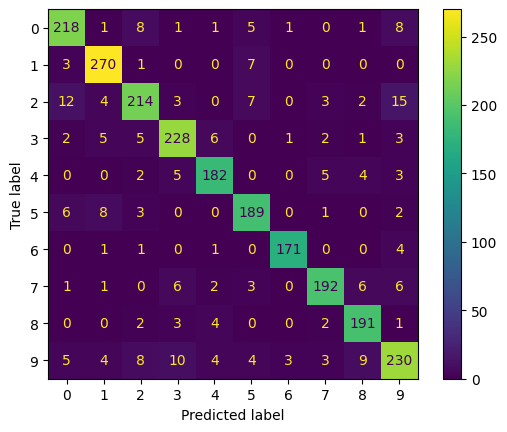

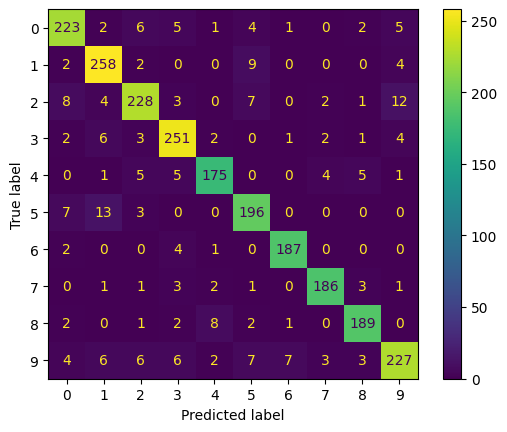

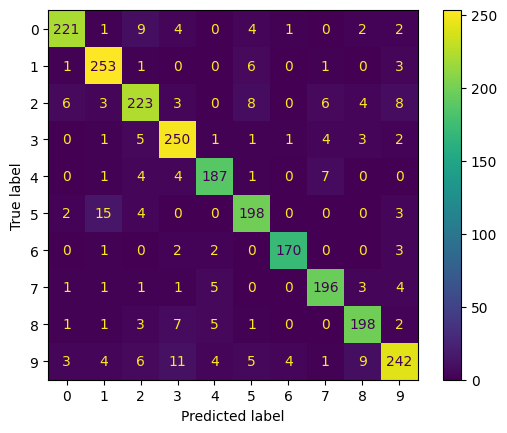

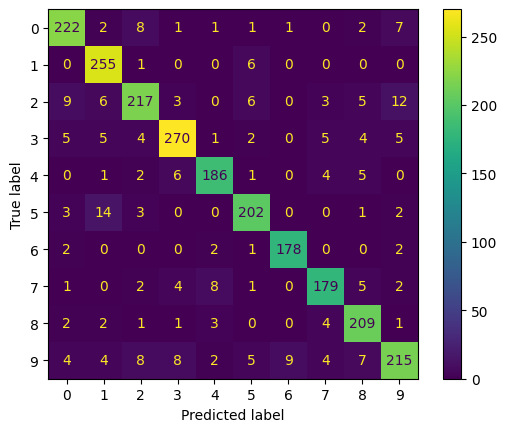

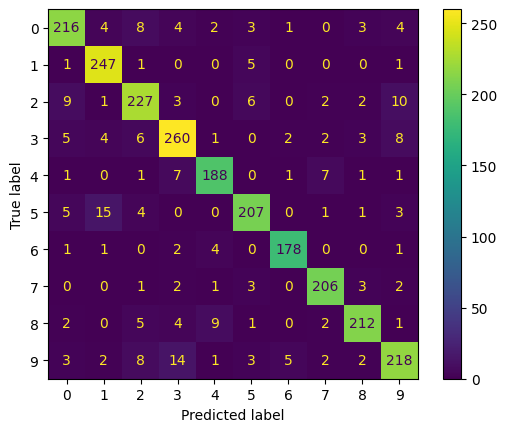

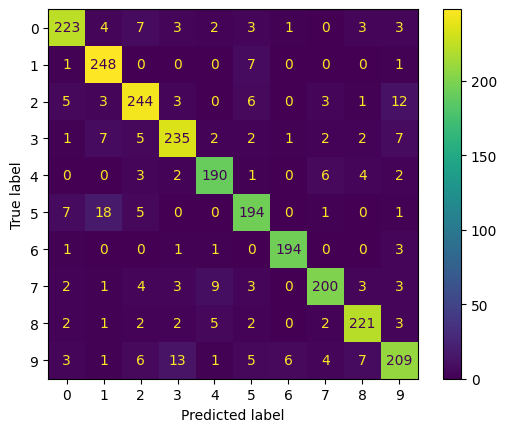

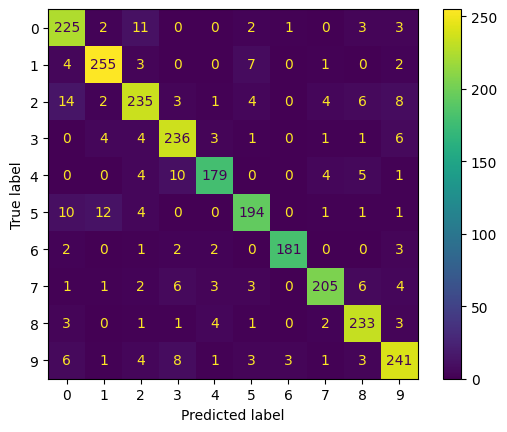

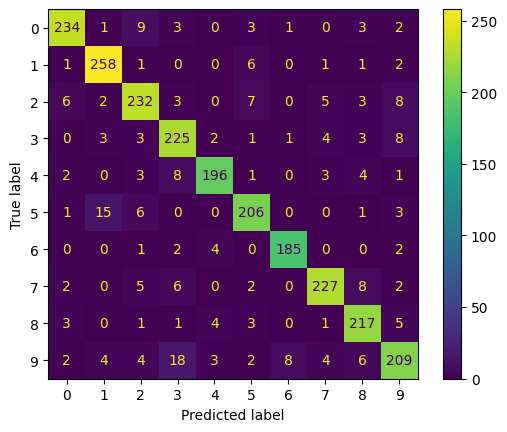

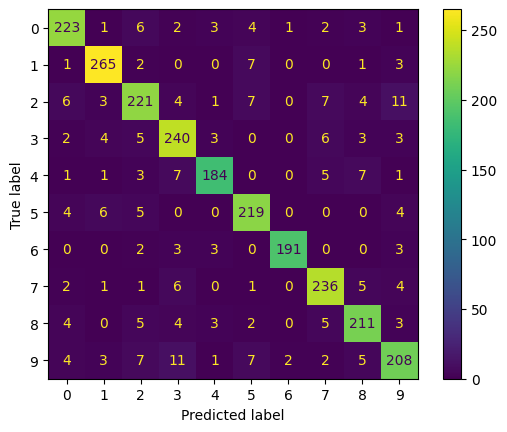

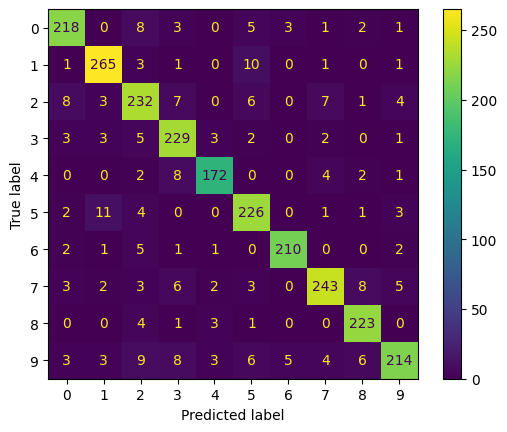

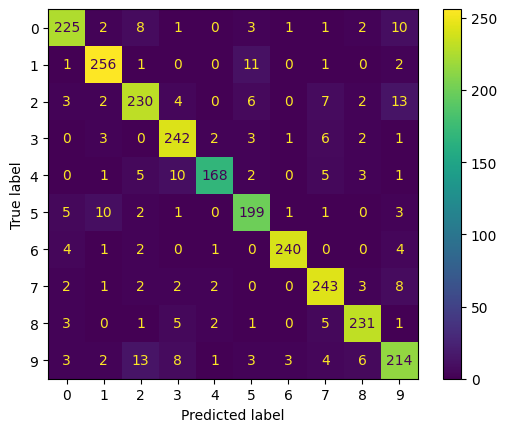

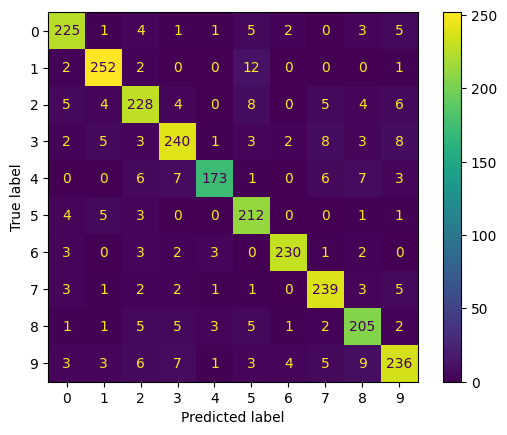

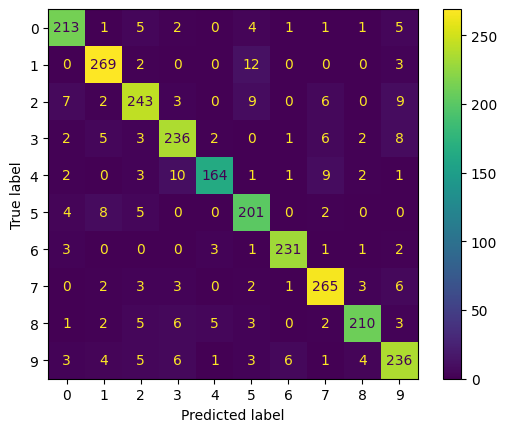

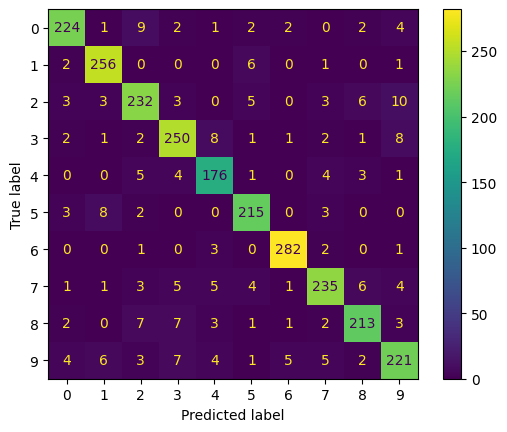

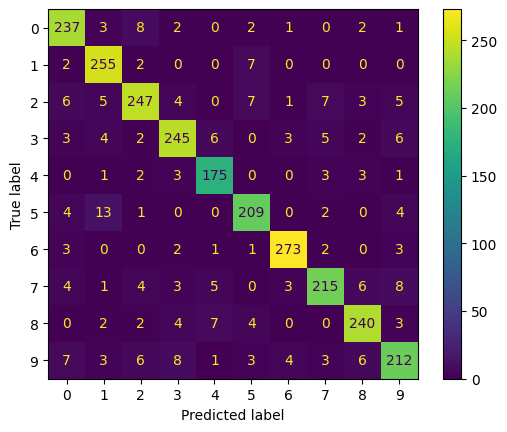

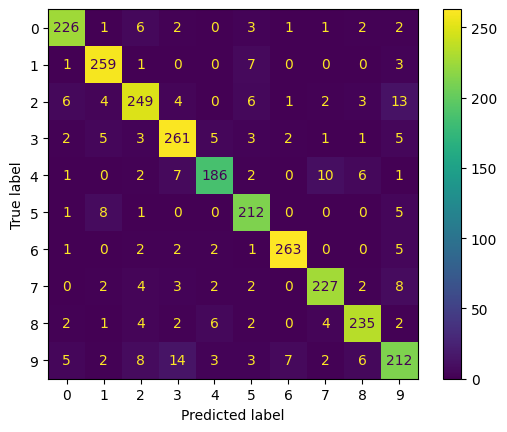

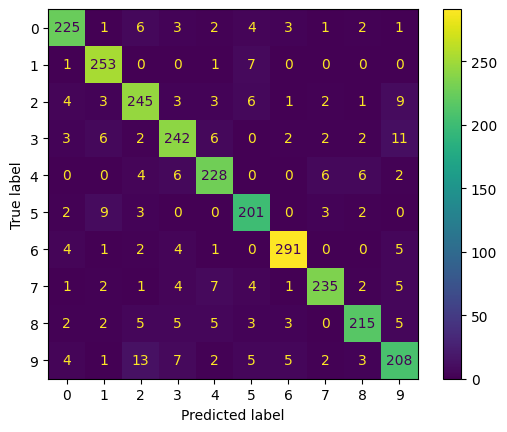

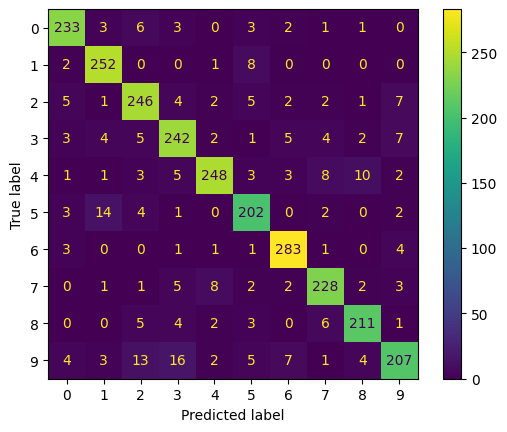

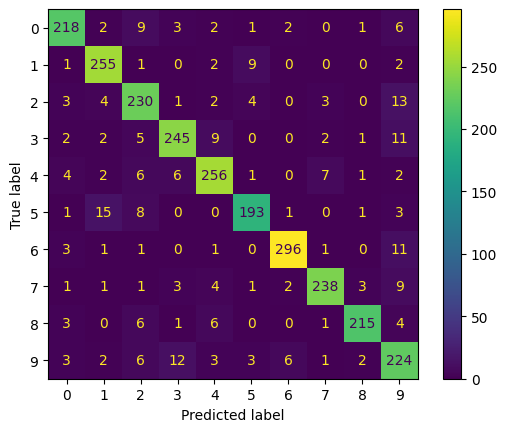

In [11]:
# TODO: Print steps

for folder_class in os.listdir('./extra_music/'):
    for song in os.listdir(f'./extra_music/{folder_class}'):

        # Preprocess input data
        print("\n1. ------------ Preprocessing ---------------\n")
        print("Song =>", song)
        print("Class =>", folder_class)
        dfs = preprocess_data(f'./extra_music/{folder_class}/{song}')

        # Load the weights
        my_model = MusicClassifier(input_features=55, output_features=10)
        my_model.load_state_dict(
            torch.load(
                f="./actual_model_fast.pth", map_location=torch.device("cpu")
            )
        )

        # Predict 
        print("\n2. ----------- Predict --------------------\n")
        my_model.eval()

        class_predictions = []
        raw_results = []

        for df in dfs:
            y_logits = my_model(torch.from_numpy(df.to_numpy()).type(torch.float32))
            y_softmax = torch.softmax(y_logits, dim=1)
            y_pred = y_softmax.argmax(dim=1)

            # print(genre_mapping[y_pred.detach().numpy()[0]])
            # print(list(torch.round(y_softmax * 1000) / 1000))

            raw_results.append(y_softmax.detach().numpy())
            class_predictions.append(genre_mapping[y_pred.detach().numpy()[0]])

        unique_values = set(class_predictions)
        actual_best = 0
        for elt in unique_values:
            if class_predictions.count(elt) > actual_best:
                actual_best = class_predictions.count(elt)
                prediction = elt
            print(elt, class_predictions.count(elt))

        print("Results =>", prediction, "(", genre_mapping_inverse[prediction], ")")

        # Filter kept data
        print("\n3. ----------- Filter kept data --------------------\n")
        real_class = int(folder_class)
        print("real_class", real_class)
        kept_dfs: List[pd.DataFrame] = []

        for i in range(len(dfs)):
            sorted_array = np.sort(raw_results[i][0])[::-1]
            # Keep only dfs when the real class i the first or second predicted by the model !
            if raw_results[i][0][real_class] == sorted_array[0] or (raw_results[i][0][real_class] == sorted_array[1] and raw_results[i][0][real_class] > 0):
                # print(raw_results[i][0][real_class])
                kept_dfs.append(dfs[i])

        # print("df_length =>",len(kept_dfs))

        print("\n4. ----------- Concat --------------------\n")
        concat_dfs(dfs, real_class)

        print("\n5. ----------- Training loop --------------------\n")
        training_loop(MusicClassifier)

# Preprocess data

# Predict

# Grow dataset with new data

# Training